In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append('./../../RoboPoint/')

from robopoint_utils import load_model, get_coordinates, generate_prompt, do_inference_with_logits, calculate_probs_per_coordinate
from utils import extract_all, plot_scatter, calculate_euclidian_distance, calculate_normalized_euclidian_distance, visualize_points_on_image, close_all_images, cluster_data, calculate_spread, show_cluster
from PIL import Image

2025-02-10 17:44:47.537001: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 17:44:47.872231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 17:44:47.872278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 17:44:47.872307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 17:44:47.889880: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"
model, processor, tokenizer = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def calculate_roc_curve(decision_values, threshold, scores):
    decision_values = np.array(decision_values)
    y_true = []
    for value in decision_values:
        if (value < threshold):
            y_true.append(1)
        else:
            y_true.append(0)
    unique_classes = np.unique(y_true)
    if len(unique_classes) < 2:
        return None, None, 0, None
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

def plot_roc_curve(fpr, tpr, roc_auc):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve for Distance-Based Classification")
    plt.legend(loc="lower right")
    plt.show()

def find_best_threshold(optimization_scores, target_scores):
    # Generate 20 evenly spaced values from min to max
    steps = np.linspace(np.array(optimization_scores).min(), np.array(optimization_scores).max(), 20)
    
    max_auc = 0
    best_threshold = 0
    for thresh in steps:
        fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_scores, thresh, target_scores)
        if (roc_auc > max_auc):
            max_auc = roc_auc
            best_threshold = thresh
    return best_threshold

In [16]:
def run_roc_experiment(prompts, temperatures, runs_per_instance, epsilon, min_samples, ignoreCoordinateDecimalPlaces, experiment_path = "../data/first_experiments"):
    tasks, images, ground_truths, object_list = extract_all(experiment_path)

    list_of_distances = []
    list_of_spreads = []
    list_of_probs = []
    list_of_diameters = []
    list_of_majority_size_rate = []
    labels = []
    for i in range(len(tasks)):
        print(f"Task: {i + 1}")
        print(tasks[i])
    
        image_path = images[i]
        task = tasks[i]
        objects = object_list[i]
        groundtruths = ground_truths[i]

        with Image.open(image_path) as image:
            width, height = image.size
            for object, groundtruth in zip(objects, groundtruths):
                coordinates_per_task = []
                probs = []
                image_labels = []

                for prompt_start in prompts:
                    prompt = generate_prompt(object, prompt_start)

                    for temperature in temperatures:
                    
                        for j in range(runs_per_instance):
                            generated_text, outputs = do_inference_with_logits(image, prompt, model, processor, tokenizer, temperature)
                            
                            coordinates = get_coordinates(generated_text, width, height)
                            if len(coordinates) == 0:
                                continue

                            first_prob = calculate_probs_per_coordinate(outputs, ignoreCoordinateDecimalPlaces)[0].item()
                            
                            image_labels.append(f"{prompt_start}({temperature})")
                            probs.append(first_prob)
                            coordinates_per_task.append(coordinates[0])
                            #coordinates_per_task += coordinates[:3]

                n_clusters, majority_points, noisy_points, centroid, diameter = cluster_data(coordinates_per_task, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters > 0):
                    distance = calculate_normalized_euclidian_distance(centroid, groundtruth, width, height)
                    #show_cluster(image, majority_points, noisy_points, centroid, diameter)
                
                    label = task + " (" + object + ")"
                    labels.append(label)
                    list_of_distances.append(distance)
                    list_of_probs.append(np.mean(probs))
                    list_of_spreads.append(calculate_spread(coordinates_per_task, width, height))
                    list_of_diameters.append(diameter)
                    list_of_majority_size_rate.append(len(majority_points) / len(coordinates_per_task))
                    
    return list_of_distances, list_of_spreads, list_of_probs, list_of_diameters, list_of_majority_size_rate

In [17]:
PROMPTS = [
    "Locate several points within the space of the ",
    "Locate several points within the area of the ",
    "Identify multiple points within the space of the ",
    "Identify several points within the area of the ",
    "Identify several spots within the space of the "
]

TEMPERATURES = [
    0.6
]


list_of_distances, list_of_spreads, list_of_probs, list_of_diameters, list_of_majority_size_rate = run_roc_experiment(
    prompts = PROMPTS,
    temperatures = TEMPERATURES,
    runs_per_instance = 3,
    epsilon = 20,
    min_samples = 3,
    ignoreCoordinateDecimalPlaces = True,
    experiment_path = "../data/base_experiments"
)

print(list_of_distances)
print(list_of_spreads)
print(list_of_probs)
print(list_of_diameters)
print(list_of_majority_size_rate)

Task: 1
pull the oven tray
Number of clusters: 1
Number of noisy points: 4
Centroid of majority cluster: [213.         138.81818182]
Diameter of majority cluster: 33.37663853655727
Task: 2
move the fruit from the left stove to the sink
Number of clusters: 1
Number of noisy points: 2
Centroid of majority cluster: [128.53846154 207.84615385]
Diameter of majority cluster: 45.617978911828175
Number of clusters: 2
Number of noisy points: 1
Centroid of majority cluster: [140.11111111 216.22222222]
Diameter of majority cluster: 49.040799340956916
Task: 3
open low fridge
Didnt find any cluster
Task: 4
open the drawer
Number of clusters: 1
Number of noisy points: 12
Centroid of majority cluster: [125.66666667 296.        ]
Diameter of majority cluster: 20.248456731316587
Task: 5
Move the can from the top left of the burner to the bottom left of the burner
Number of clusters: 1
Number of noisy points: 1
Centroid of majority cluster: [179.21428571 122.07142857]
Diameter of majority cluster: 48.16

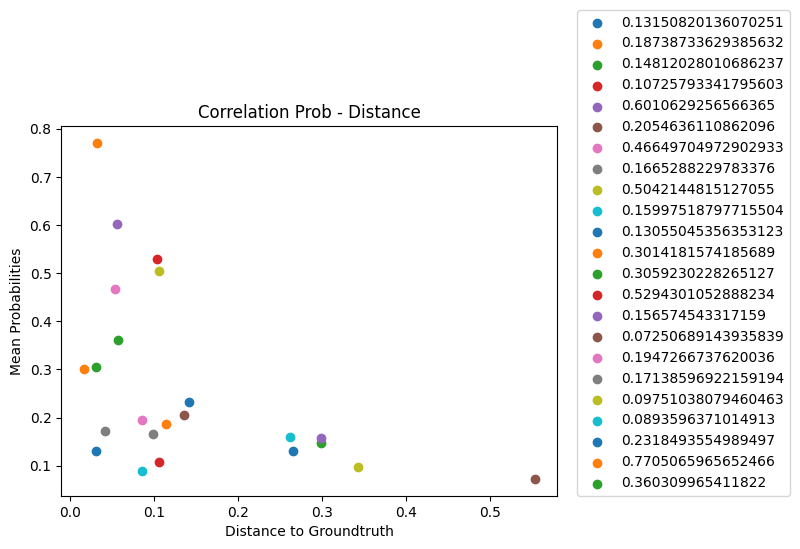

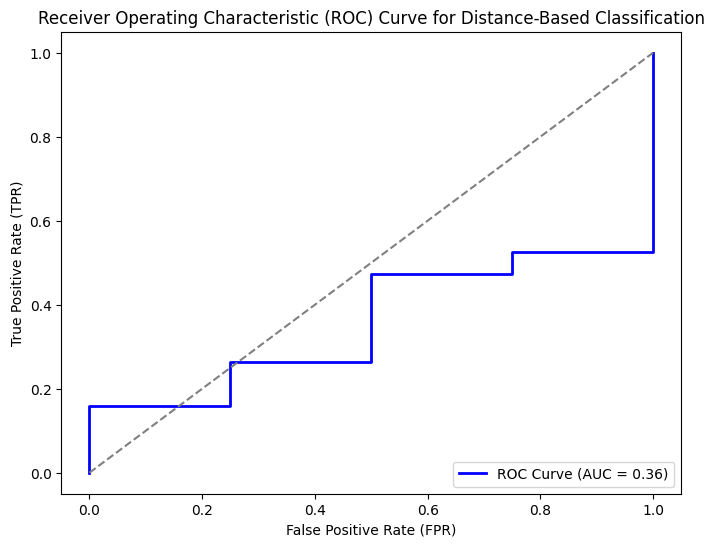

Optimal threshold: 0.47661198388066206


In [26]:
plot_scatter(list_of_probs, list_of_probs, list_of_distances, "Correlation Prob - Distance", "Distance to Groundtruth", "Mean Probabilities")

optimization_values = list_of_probs
scores = 1 - np.array(list_of_distances)

thresh = find_best_threshold(optimization_values, scores)
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, thresh, scores)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"Optimal threshold: {thresh}")

[0.         0.09090909 0.18181818 0.18181818 0.54545455 0.54545455
 0.63636364 0.63636364 0.81818182 0.81818182 0.90909091 0.90909091
 1.         1.        ]
[0.         0.         0.         0.16666667 0.16666667 0.33333333
 0.33333333 0.41666667 0.41666667 0.75       0.75       0.91666667
 0.91666667 1.        ]
0.3181818181818182
[       inf 0.7705066  0.60106293 0.50421448 0.30141816 0.20546361
 0.19472667 0.18738734 0.16652882 0.1315082  0.13055045 0.09751038
 0.08935964 0.07250689]


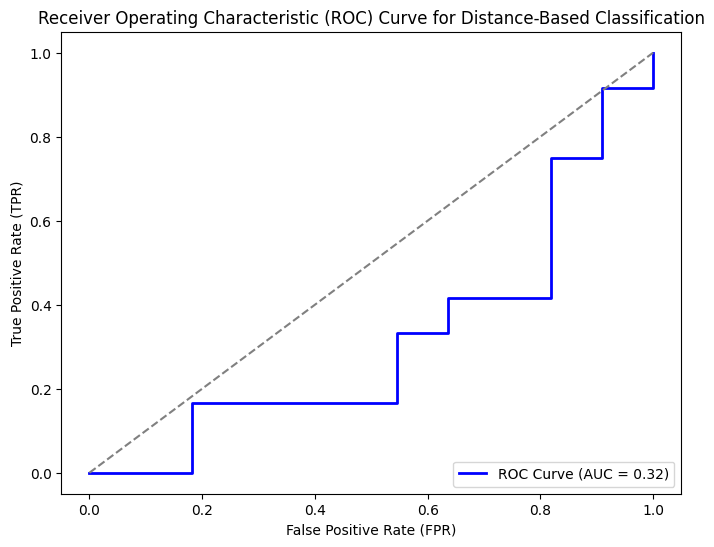

In [42]:
optimization_values = 1 - np.array(list_of_distances)
scores = list_of_probs

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, 0.9, scores)
print(fpr)
print(tpr)
print(roc_auc)
print(thresholds)
plot_roc_curve(fpr, tpr, roc_auc)

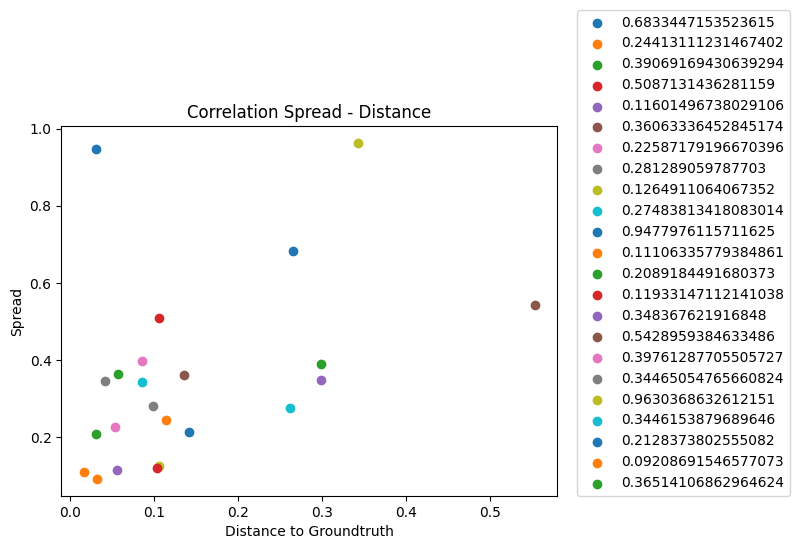

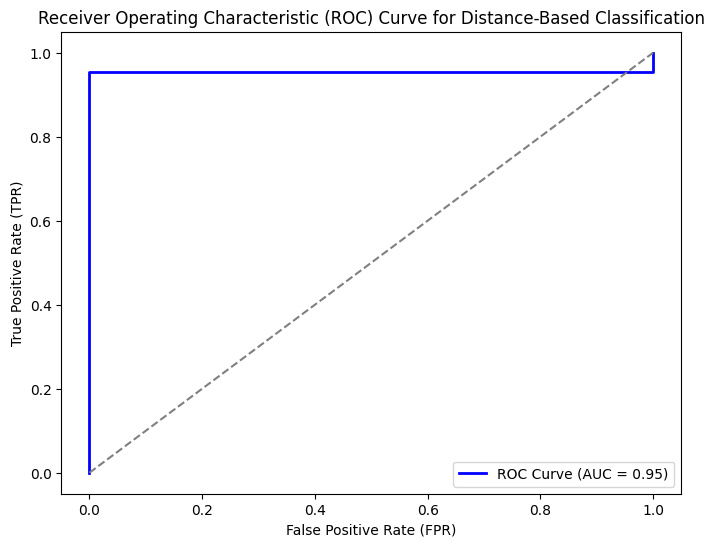

Optimal threshold: 0.9630368632612151


In [29]:
plot_scatter(list_of_spreads, list_of_spreads, list_of_distances, "Correlation Spread - Distance", "Distance to Groundtruth", "Spread")

optimization_values = list_of_spreads
scores = 1 - np.array(list_of_distances)

thresh = find_best_threshold(optimization_values, scores)
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, thresh, scores)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"Optimal threshold: {thresh}")

[0.         0.09090909 0.27272727 0.27272727 0.36363636 0.36363636
 0.45454545 0.45454545 0.72727273 0.72727273 0.81818182 0.81818182
 0.90909091 0.90909091 1.         1.        ]
[0.         0.         0.         0.16666667 0.16666667 0.25
 0.25       0.41666667 0.41666667 0.58333333 0.58333333 0.66666667
 0.66666667 0.91666667 0.91666667 1.        ]
0.3484848484848485
[       inf 0.90791308 0.88398503 0.87350889 0.79108155 0.78716262
 0.77412821 0.72516187 0.65534945 0.63936664 0.63485893 0.60930831
 0.60238712 0.31665528 0.05220239 0.03696314]


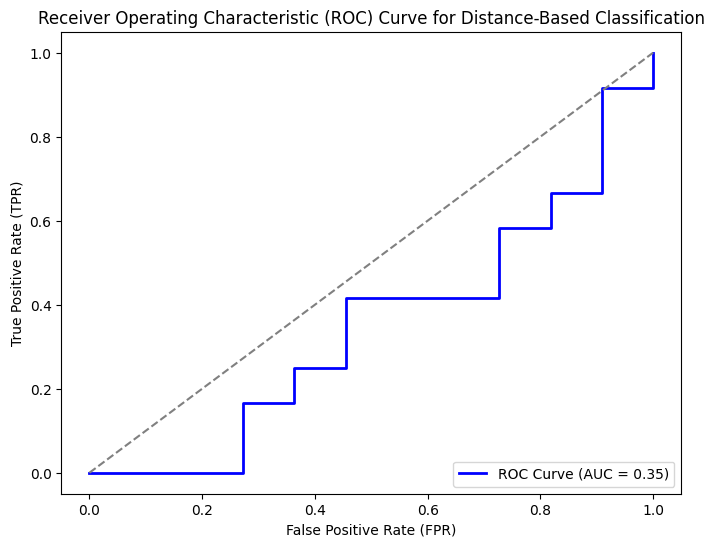

In [45]:
optimization_values = 1 - np.array(list_of_distances)
scores = 1 - np.array(list_of_spreads)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, 0.9, scores)
print(fpr)
print(tpr)
print(roc_auc)
print(thresholds)
plot_roc_curve(fpr, tpr, roc_auc)

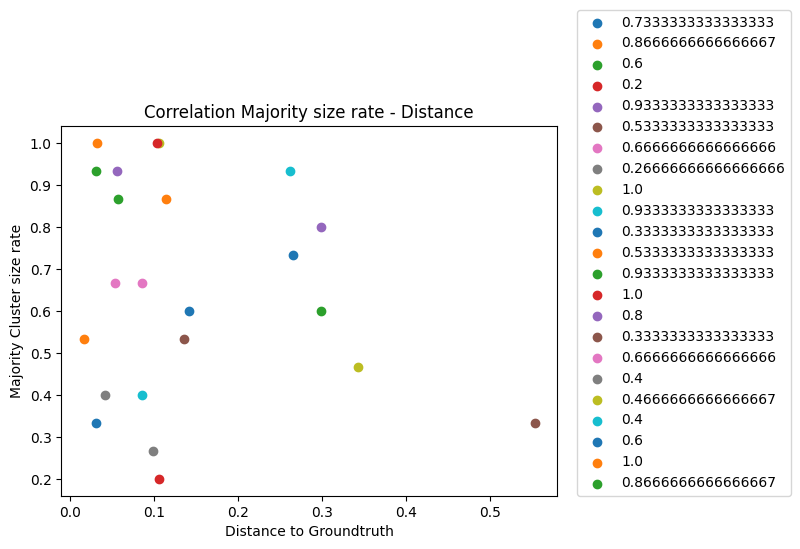

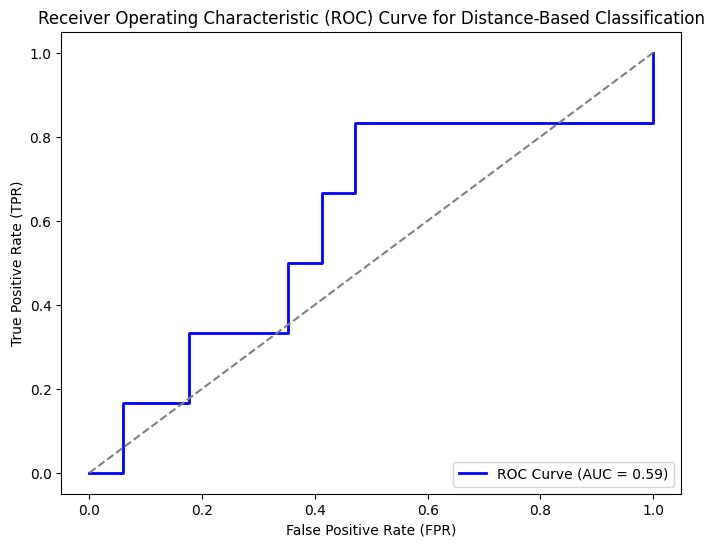

Optimal threshold: 0.4105263157894737


In [30]:
plot_scatter(list_of_majority_size_rate, list_of_majority_size_rate, list_of_distances, "Correlation Majority size rate - Distance", "Distance to Groundtruth", "Majority Cluster size rate")

optimization_values = list_of_majority_size_rate
scores = 1 - np.array(list_of_distances)

thresh = find_best_threshold(optimization_values, scores)
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, thresh, scores)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"Optimal threshold: {thresh}")

[0.         0.09090909 0.27272727 0.36363636 0.36363636 0.54545455
 0.54545455 0.63636364 0.63636364 0.81818182 0.90909091 1.
 1.        ]
[0.         0.16666667 0.25       0.33333333 0.5        0.5
 0.66666667 0.75       0.83333333 0.83333333 0.91666667 0.91666667
 1.        ]
0.5416666666666666
[       inf 1.         0.93333333 0.86666667 0.73333333 0.66666667
 0.6        0.53333333 0.46666667 0.4        0.33333333 0.26666667
 0.2       ]


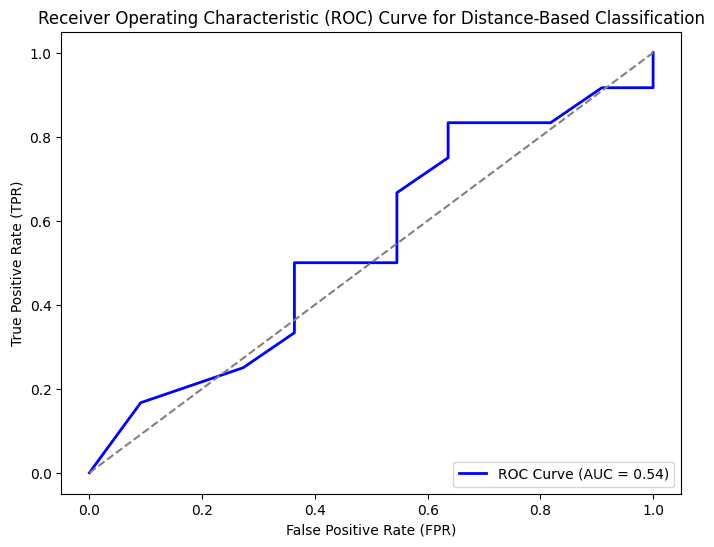

In [43]:
optimization_values = 1 - np.array(list_of_distances)
scores = list_of_majority_size_rate

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, 0.9, scores)
print(fpr)
print(tpr)
print(roc_auc)
print(thresholds)
plot_roc_curve(fpr, tpr, roc_auc)

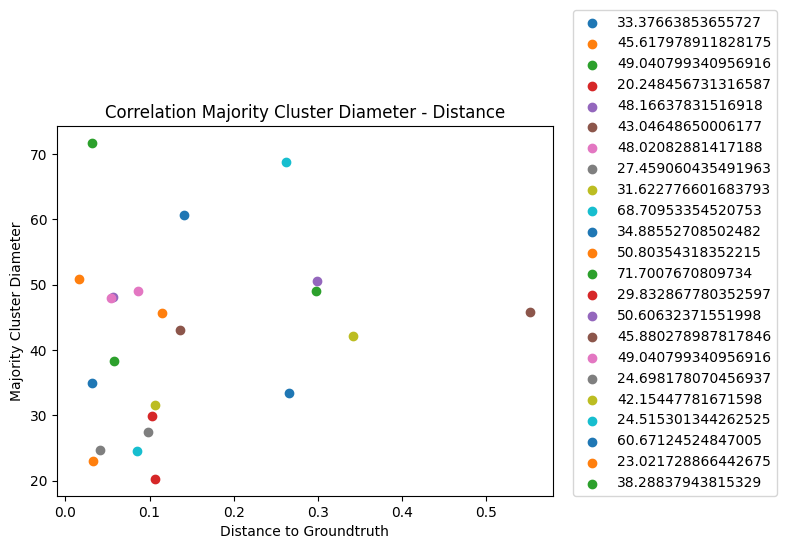

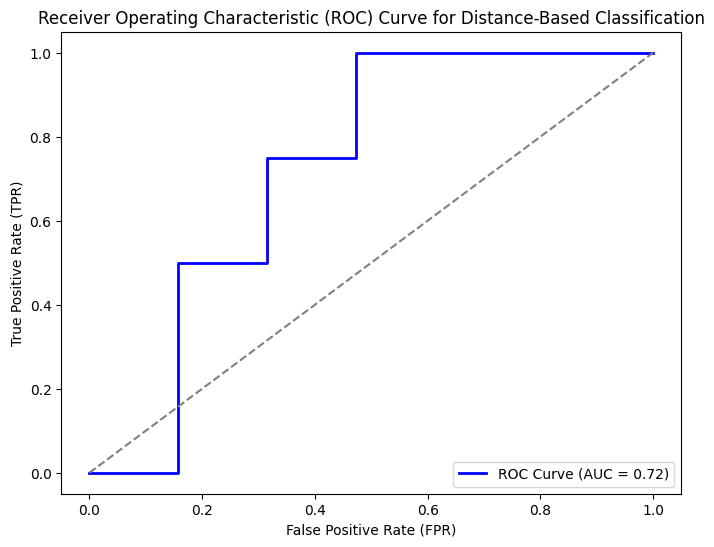

Optimal threshold: 25.664489399701516


In [31]:
plot_scatter(list_of_diameters, list_of_diameters, list_of_distances, "Correlation Majority Cluster Diameter - Distance", "Distance to Groundtruth", "Majority Cluster Diameter")

optimization_values = list_of_diameters
scores = 1 - np.array(list_of_distances)

thresh = find_best_threshold(optimization_values, scores)
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(optimization_values, thresh, scores)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"Optimal threshold: {thresh}")